In [1]:
import os
import numpy as np
import pathlib
from pathlib import Path
import shutil
import random
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import warnings

warnings.filterwarnings('ignore')

E0000 00:00:1754380411.711032    6607 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754380411.717859    6607 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754380411.734720    6607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754380411.734736    6607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754380411.734738    6607 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754380411.734740    6607 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
def crop_brain_region(image, margin=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    x, y, w, h = cv2.boundingRect(np.vstack(contours))
    x, y = max(x - margin, 0), max(y - margin, 0)
    x2, y2 = min(x + w + margin * 2, image.shape[1]), min(y + h + margin * 2, image.shape[0])
    return image[y:y2, x:x2]

def resize_and_pad(image, target_size=224):
    h, w, _ = image.shape
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    delta_w, delta_h = target_size - new_w, target_size - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def preprocess_image_from_path(path_str, target_size=224):
    image = cv2.imread(path_str)
    if image is None: return None
    cropped = crop_brain_region(image, margin=10)
    if cropped is None: return None
    processed = resize_and_pad(cropped, target_size)
    return processed

def preprocess_and_copy_images(img_path_list, dst_dir, target_size):
    for img_path in tqdm(img_path_list, desc=f"  Processing and copying", leave=False):
        processed_img = preprocess_image_from_path(img_path, target_size)
        if processed_img is not None:
            filename = os.path.basename(img_path)
            cv2.imwrite(os.path.join(dst_dir, filename), processed_img)

def augment_images(image_paths, needed, dst_dir, augmentor, seed, target_size):
    generated = 0
    idx = 0
    if not image_paths:
        print(f"  [❌] Không có ảnh gốc để augment.")
        return
    pbar = tqdm(total=needed, desc=f"  Augmenting images", leave=False)
    while generated < needed:
        img_path = image_paths[idx % len(image_paths)]
        processed_img = preprocess_image_from_path(img_path, target_size)
        if processed_img is None:
            idx += 1
            continue
        x = img_to_array(processed_img)
        x = x.reshape((1,) + x.shape)
        for batch in augmentor.flow(x, batch_size=1, seed=seed):
            new_img = array_to_img(batch[0])
            save_path = os.path.join(dst_dir, f"aug_{generated}_{os.path.basename(img_path)}")
            new_img.save(save_path) # Dòng này sẽ không còn lỗi nữa
            generated += 1
            pbar.update(1)
            break
        idx += 1
    pbar.close()

def visualize_and_save_processed_data(processed_dir, save_dir, n_images=16):
    # ... (hàm này không thay đổi) ...
    print(f"\n🎨 Bắt đầu trực quan hóa {n_images} ảnh ngẫu nhiên...")
    processed_path = Path(processed_dir)
    all_image_paths = list(processed_path.rglob('*.*'))
    if len(all_image_paths) < n_images:
        print(f"  [⚠] Không đủ ảnh để trực quan hóa.")
        return
    selected_paths = random.sample(all_image_paths, n_images)
    plt.figure(figsize=(12, 12))
    plt.suptitle("16 ảnh ngẫu nhiên sau khi tiền xử lý", fontsize=20)
    for i, img_path in enumerate(selected_paths):
        plt.subplot(4, 4, i + 1)
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        class_name = img_path.parent.name
        split_name = img_path.parent.parent.name
        plt.title(f"{split_name.capitalize()}/{class_name}", fontsize=10)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    save_path = os.path.join(save_dir, 'processed_data_visualization.png')
    plt.savefig(save_path)
    print(f"✅ Biểu đồ đã được lưu tại: {save_path}")
    plt.show()

🔄 Đảm bảo các thư mục đích tồn tại tại: ../processedDatasets/data_balanced/

🔥 Bắt đầu quy trình xử lý và cân bằng dữ liệu...

📂 Class 'Non_Dementia':


  [✔] Hoàn thành: 5000 ảnh (gốc: 67222, augment: 0)

📂 Class 'Very_mild_Dementia':


  [✔] Hoàn thành: 5000 ảnh (gốc: 13725, augment: 0)

📂 Class 'Mild_Dementia':


  [✔] Hoàn thành: 5000 ảnh (gốc: 5002, augment: 0)

📂 Class 'Moderate_Dementia':


  [ℹ] Cần 4512 ảnh, sẽ augment vào tập 'train'...


  [✔] Hoàn thành: 5000 ảnh (gốc: 488, augment: 4512)

🎉🎉🎉 Quy trình hoàn tất! Dữ liệu đã được xử lý và lưu tại: ../processedDatasets/data_balanced/

🎨 Bắt đầu trực quan hóa 16 ảnh ngẫu nhiên...
✅ Biểu đồ đã được lưu tại: ../reports/processed_data_visualization.png


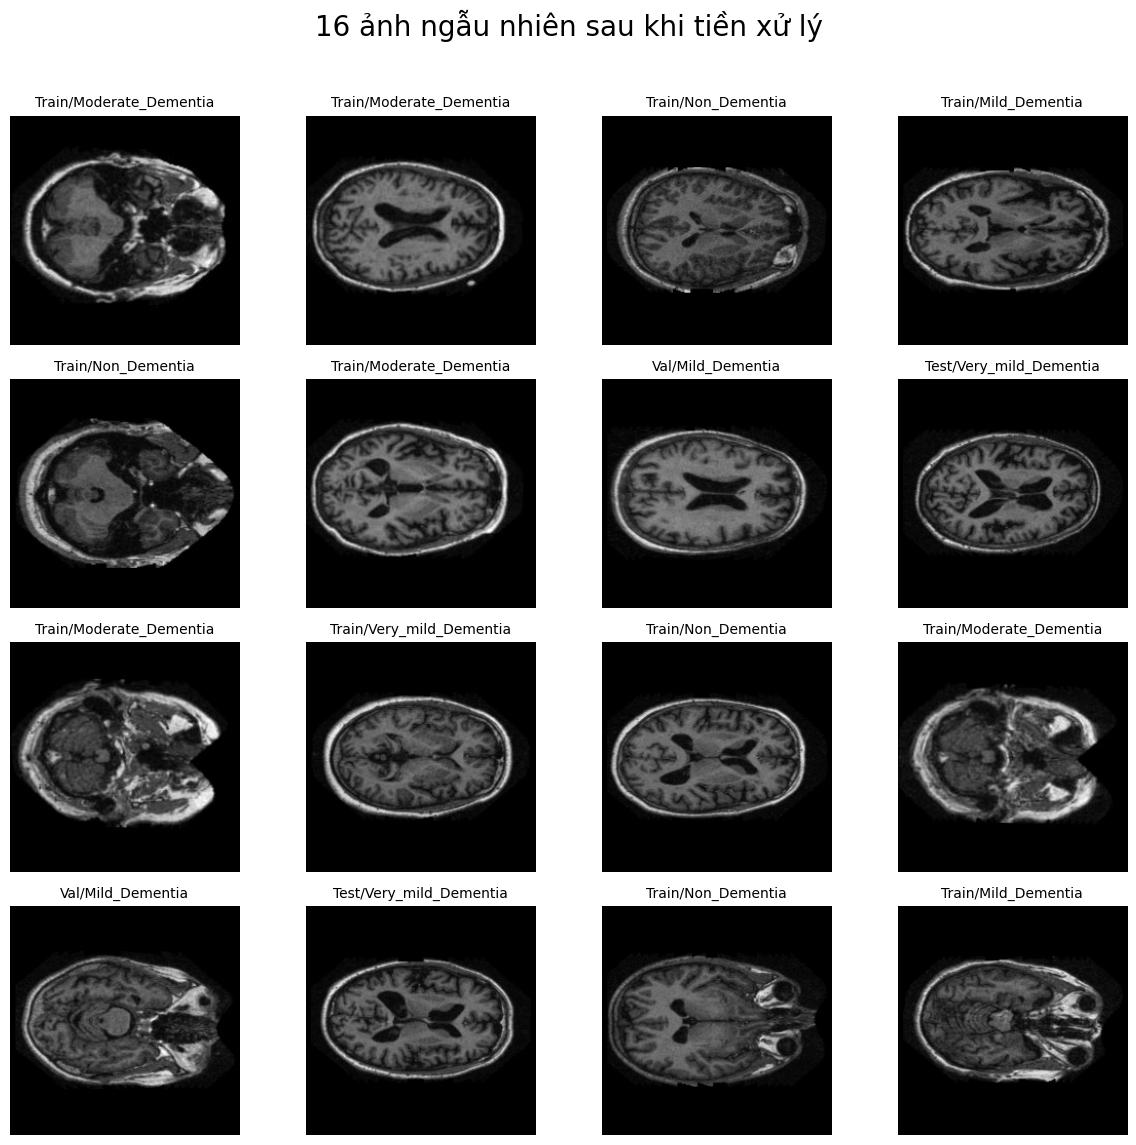

In [3]:
SOURCE_DIR = '../../datasets/OASIS_Alzheimer_Detection/Data/'
TARGET_DIR = '../processedDatasets/data_balanced/'
REPORTS_DIR = '../reports/figures/'
CLASSES = ['Non_Dementia', 'Very_mild_Dementia', 'Mild_Dementia', 'Moderate_Dementia']
TARGET_SAMPLES_PER_CLASS = 5000
RATIOS = {'train': 0.7, 'val': 0.15, 'test': 0.15}
SEED = 42
TARGET_SIZE = 224

augmentor_instance = ImageDataGenerator(
    rotation_range=5, width_shift_range=0.03, height_shift_range=0.03,
    zoom_range=0.05, horizontal_flip=False, fill_mode='nearest'
)

# ==============================================================================
# PHẦN TẠO THƯ MỤC (ĐÃ THÊM LẠI ĐỂ SỬA LỖI VÀ ĐẢM BẢO AN TOÀN)
# ==============================================================================
# Cách làm tốt nhất là luôn để script tự kiểm tra và tạo thư mục nếu cần.
# Lệnh này sẽ không làm gì nếu thư mục đã tồn tại, nên nó rất an toàn.
print(f"🔄 Đảm bảo các thư mục đích tồn tại tại: {TARGET_DIR}")
os.makedirs(REPORTS_DIR, exist_ok=True)
for split in RATIOS.keys():
    for cls in CLASSES:
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

# === VÒNG LẶP XỬ LÝ CHÍNH ===
print("\n🔥 Bắt đầu quy trình xử lý và cân bằng dữ liệu...")
for cls in CLASSES:
    print(f"\n📂 Class '{cls}':")
    cls_path = Path(SOURCE_DIR) / cls
    all_images = [str(p) for p in cls_path.glob('*.*') if p.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    original_count = len(all_images)
    if not all_images:
        print(f"  [⚠] Không tìm thấy ảnh. Bỏ qua class này.")
        continue

    if original_count >= TARGET_SAMPLES_PER_CLASS:
        sampled_images = random.sample(all_images, TARGET_SAMPLES_PER_CLASS)
        augment_needed = 0
    else:
        sampled_images = all_images.copy()
        augment_needed = TARGET_SAMPLES_PER_CLASS - original_count

    random.seed(SEED)
    random.shuffle(sampled_images)
    
    total_original_split = len(sampled_images)
    n_train_orig = int(total_original_split * RATIOS['train'])
    n_val_orig = int(total_original_split * RATIOS['val'])
    
    train_imgs = sampled_images[:n_train_orig]
    val_imgs = sampled_images[n_train_orig : n_train_orig + n_val_orig]
    test_imgs = sampled_images[n_train_orig + n_val_orig:]

    preprocess_and_copy_images(train_imgs, os.path.join(TARGET_DIR, 'train', cls), TARGET_SIZE)
    preprocess_and_copy_images(val_imgs, os.path.join(TARGET_DIR, 'val', cls), TARGET_SIZE)
    preprocess_and_copy_images(test_imgs, os.path.join(TARGET_DIR, 'test', cls), TARGET_SIZE)

    if augment_needed > 0:
        print(f"  [ℹ] Cần {augment_needed} ảnh, sẽ augment vào tập 'train'...")
        augment_images(all_images, augment_needed, os.path.join(TARGET_DIR, 'train', cls), augmentor_instance, SEED, TARGET_SIZE)

    print(f"  [✔] Hoàn thành: {TARGET_SAMPLES_PER_CLASS} ảnh (gốc: {original_count}, augment: {augment_needed})")

print(f"\n🎉🎉🎉 Quy trình hoàn tất! Dữ liệu đã được xử lý và lưu tại: {TARGET_DIR}")

# === TRỰC QUAN HÓA KẾT QUẢ CUỐI CÙNG ===
visualize_and_save_processed_data(TARGET_DIR, REPORTS_DIR)